# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [2]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached pymongo-4.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (500 kB)
  Using cached dnspython-2.2.1-py3-none-any.whl (269 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 2.5 MB/s eta 0:00:00a 0:00:01
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 29.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 11.7 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [7]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [8]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [9]:
client = MongoClient(mongod_connect)
db = client.demo # use or create a database named demo
tweet_collection = db.lab9 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [24]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [25]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [31]:
class MyStreamListener(Stream):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 14 22:04:03 +0000 2022'
'Mon Nov 14 21:56:53 +0000 2022'
'Mon Nov 14 21:53:29 +0000 2022'
'Mon Nov 14 21:50:33 +0000 2022'
'Mon Nov 14 21:48:51 +0000 2022'
'Mon Nov 14 21:43:23 +0000 2022'
'Mon Nov 14 21:40:58 +0000 2022'
'Mon Nov 14 21:34:17 +0000 2022'
'Mon Nov 14 21:33:33 +0000 2022'
'Mon Nov 14 21:33:13 +0000 2022'
'Mon Nov 14 21:25:16 +0000 2022'
'Mon Nov 14 21:22:16 +0000 2022'
'Mon Nov 14 21:18:43 +0000 2022'
'Mon Nov 14 21:08:40 +0000 2022'
'Mon Nov 14 20:34:09 +0000 2022'
'Mon Nov 14 20:27:13 +0000 2022'
'Mon Nov 14 20:12:51 +0000 2022'
'Mon Nov 14 20:12:44 +0000 2022'
'Mon Nov 14 20:07:18 +0000 2022'
'Mon Nov 14 20:05:24 +0000 2022'
'Mon Nov 14 19:50:48 +0000 2022'
'Mon Nov 14 19:35:02 +0000 2022'
'Mon Nov 14 19:34:23 +0000 2022'
'Mon Nov 14 19:26:56 +0000 2022'
'Mon Nov 14 19:21:33 +0000 2022'
'Mon Nov 14 19:20:52 +0000 2022'
'Mon Nov 14 19:19:16 +0000 2022'
'Mon Nov 14 19:08:28 +0000 2022'
'Mon Nov 14 19:06:58 +0000 2022'
'Mon Nov 14 19:05:34 +0000 2022'
'Mon Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 14 11:32:47 +0000 2022'
'Mon Nov 14 11:30:53 +0000 2022'
'Mon Nov 14 11:07:30 +0000 2022'
'Mon Nov 14 09:44:09 +0000 2022'
'Mon Nov 14 09:30:49 +0000 2022'
'Mon Nov 14 09:17:42 +0000 2022'
'Mon Nov 14 09:09:13 +0000 2022'
'Mon Nov 14 09:01:19 +0000 2022'
'Mon Nov 14 08:03:08 +0000 2022'
'Mon Nov 14 07:41:23 +0000 2022'
'Mon Nov 14 07:38:45 +0000 2022'
'Mon Nov 14 07:20:23 +0000 2022'
'Mon Nov 14 07:19:30 +0000 2022'
'Mon Nov 14 07:04:51 +0000 2022'
'Mon Nov 14 07:00:47 +0000 2022'
'Mon Nov 14 06:58:19 +0000 2022'
'Mon Nov 14 06:30:57 +0000 2022'
'Mon Nov 14 05:11:14 +0000 2022'
'Mon Nov 14 05:04:59 +0000 2022'
'Mon Nov 14 05:01:10 +0000 2022'
'Mon Nov 14 05:00:02 +0000 2022'
'Mon Nov 14 04:50:46 +0000 2022'
'Mon Nov 14 04:47:31 +0000 2022'
'Mon Nov 14 04:35:36 +0000 2022'
'Mon Nov 14 04:30:31 +0000 2022'
'Mon Nov 14 03:59:04 +0000 2022'
'Mon Nov 14 03:54:01 +0000 2022'
'Mon Nov 14 03:23:32 +0000 2022'
'Mon Nov 14 03:19:51 +0000 2022'
'Mon Nov 14 03:15:57 +0000 2022'
'Mon Nov 1

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2375
1043


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Sheila
text: I voted!! Make your vote count and your voice to be heard! #voting #vote #election #elections2022 #votingrights… https://t.co/1WJNDgCUvl
----
name: fooddude
text: @ebznfloze @Garrett_Archer The majority of votes left to be counted were election day votes and drop off votes.
----
name: Robbie Cooper (Psn DatLie)
text: @Froskurinn Easy to lose when votes get counted days after election. If you can’t vote in person your not worth a vote
----
name: JesseGibsonforAR
text: It’s Election Day in Arkansas!  Get out and vote, vote, VOTE!  #jg4ag #arpx. #arkansas https://t.co/0zCtq6wY9C
----
name: Ty Kinney
text: @LePetiteLeRoux The rest of the votes are from heavily Republican districts, or votes from people who voted today(R… https://t.co/ALDUFjeY9m
----
name: Hugh Wiggins
text: Call your state representatives and hammer them on doing away with early voting ,mail in voting absentee voting for… https://t.co/R0C68Jvhjt
----
name: Madison Center for Civic Engagement
text: E

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,6372bf5990940354bfa9bb22,Tue Nov 08 14:43:36 +0000 2022,1589992036643512320,1589992036643512320,I voted!! Make your vote count and your voice ...,True,"{'hashtags': [{'text': 'voting', 'indices': [5...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1,6372bf4190940354bfa9b6f2,Thu Nov 10 21:26:35 +0000 2022,1590818226208116736,1590818226208116736,@ebznfloze @Garrett_Archer The majority of vot...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.590783e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
2,6372bf3590940354bfa9b4bc,Mon Nov 14 00:28:01 +0000 2022,1591951047618068480,1591951047618068480,@Froskurinn Easy to lose when votes get counte...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591675e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
3,6372bf5b90940354bfa9bb75,Tue Nov 08 13:04:30 +0000 2022,1589967097861312513,1589967097861312513,It’s Election Day in Arkansas! Get out and vo...,False,"{'hashtags': [{'text': 'jg4ag', 'indices': [63...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,44,144,False,False,False,en,"{'media': [{'id': 1589966908731834370, 'id_str...",NaN,NaN,NaN
4,6372bf4d90940354bfa9b929,Wed Nov 09 04:38:58 +0000 2022,1590202263532077056,1590202263532077056,@LePetiteLeRoux The rest of the votes are from...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.590202e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
5,6372bf3490940354bfa9b49a,Mon Nov 14 04:35:36 +0000 2022,1592013352208842752,1592013352208842752,Call your state representatives and hammer the...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
6,6372bf5f90940354bfa9bc3a,Mon Nov 07 21:09:04 +0000 2022,1589726652883668992,1589726652883668992,Episode 3 of the student-led Dukes Vote Podcas...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,2,False,False,False,en,NaN,NaN,NaN,NaN
7,6372bf5f90940354bfa9bc62,Mon Nov 07 18:57:40 +0000 2022,1589693583409352706,1589693583409352706,Say yes to voting. Tomorrow is Election Day ge...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,4,5,False,False,False,en,NaN,NaN,NaN,NaN
8,6372bf5f90940354bfa9bc42,Mon Nov 07 20:48:19 +0000 2022,1589721430534811649,1589721430534811649,GO VOTE TOMORROW! We have to win this election...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3,1,False,False,NaN,en,NaN,NaN,NaN,NaN
9,6372bf6090940354bfa9bc9b,Mon Nov 07 16:09:08 +0000 2022,1589651173774184448,1589651173774184448,Tomorrow is Election Day! If you haven’t voted...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.hubspot.com/"" rel=""nofollo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

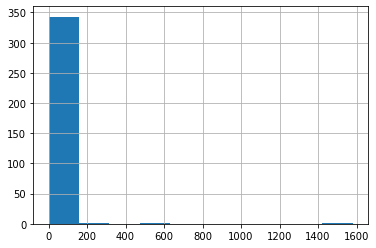

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count